# Homework 2 Group 7

- First download the MNIST dataset from http://yann.lecun.com/exdb/mnist/ and put it in a folder called MNIST on the same level as this notebook (or change the base_path under `data preparation and visualization` to the folder where you saved the dataset)

## General setup

In [1]:
# Main imports
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

In [2]:
# General tensorflow settings
config = tf.ConfigProto()
# Use GPU in incremental mode (is ignored on CPU version)
config.gpu_options.allow_growth=True
# Add config=config in every tf.Session() -> tf.Session(config=config)

In [3]:
# Helper function to read the data
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

## Data preparation and visualization

In [4]:
# Read all training and validation data
base_path = './MNIST/'

# Read training data and labels
training_data = read_idx('{}train-images.idx3-ubyte'.format(base_path))
training_labels = read_idx('{}train-labels.idx1-ubyte'.format(base_path))

# Read validation data and labels
validation_data = read_idx('{}t10k-images.idx3-ubyte'.format(base_path))
validation_labels = read_idx('{}t10k-labels.idx1-ubyte'.format(base_path))


# Print some information about the data
print('Training data shape: {}'.format(training_data.shape))
print('Training labels shape: {}'.format(training_labels.shape))

print('Validation data shape: {}'.format(validation_data.shape))
print('Validation labels shape: {}'.format(validation_labels.shape))

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Validation data shape: (10000, 28, 28)
Validation labels shape: (10000,)


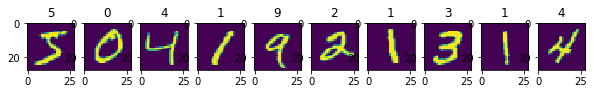

In [5]:
# Visualize the first 10 images from the training data set

# Create a figure with 10 subplots
fig, ax = plt.subplots(1,10,figsize=(10,10))

# Loop over the 10 subplots and print the corresponding image
for i in range(10):
    # Get the corresponing label and set it as the title of the plot
    ax[i].set_title(training_labels[i])
    # Show the image
    ax[i].imshow(training_data[i])

In [6]:
# Create the dataset for tensorflow

# First we reset the graph
tf.reset_default_graph()

# Now we use the tf.data library to create a tensorflow dataset
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))

# Now we specifiy the respective batch sizes
training_batch_size = 128
validation_batch_size = 10000
training_dataset = training_dataset.batch(training_batch_size)
validation_dataset = validation_dataset.batch(validation_batch_size)

# Shuffle the training data in each epoch.
training_dataset = training_dataset.shuffle(buffer_size=128, reshuffle_each_iteration=True)

In [7]:
# Create the iterator 

# First we create the iterator
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)

# We name the get_next method of the iterator to use it as a shortcut
next_batch = iterator.get_next()

# We prepare the initializer operations for both the training and the validation dataset
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

## Building the model

![](https://i.imgur.com/cRjXO96.png)

In [8]:
# First we will format the data in the correct way

# We define our input data and the corresponding labels
input_data = next_batch[0]
labels = next_batch[1]

# We reshape our data
# The first dimension (batch_size) stays the same and the second and third dimension collapses to one dimension
input_data = tf.reshape(input_data, shape=[-1,784])
# We have to cast the data to float32 (from uint8)
input_data = tf.cast(input_data, dtype=tf.float32)

# We transform our labels to one hot vectors
one_hot_labels = tf.one_hot(labels, 10)

In [9]:
# Now we will define the forward step 

# First we will define the weights and the biases
a = tf.random_normal([784,10], stddev = 2e-06)
weights = tf.Variable(a, dtype=tf.float32)

b = tf.zeros(10)
biases = tf.Variable(b, dtype=tf.float32)

# Now we will mutiply the input with the weights to get the drive (logits)
logits = input_data @ weights + biases

# And use the softmax activation function
output = tf.nn.softmax(logits)

In [10]:
# Then we have to define our metrics

# Calculate the cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_labels, logits=logits)
loss = tf.reduce_mean(cross_entropy)

# Define the accuracy 
accuracy_all = tf.cast(tf.equal(labels, tf.cast(tf.argmax(output, axis=1), dtype=tf.uint8)), dtype=tf.uint8)
accuracy = tf.reduce_mean(accuracy_all)

In [11]:
# We also have to define our optimizer

# First we need to specify a learning rate 
learning_rate = 1e-5
# Then we create an optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
# And tell the optimizer that it should minimize the loss
training_step = optimizer.minimize(loss)

In [12]:
# In the end we will specify some summaries, so that we can visualize our progress with tensorboard

# Specify the variables for the summaries
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)

# Now we will merge our two summary scalars
merged_summaries = tf.summary.merge_all()

# We also have two specify two summary file writers 
train_writer = tf.summary.FileWriter('./summaries/train/')
validation_writer = tf.summary.FileWriter('./summaries/validation/', flush_secs=1)

## Training

In [13]:
# Finally we can train our model

# First we specify the number of epochs
epochs = 5

# We safely create our tensorflow session and pass our config parameters (for correct GPU usage, if GPU available)
with tf.Session(config=config) as sess:
    
    # We initialize our variables
    sess.run(tf.global_variables_initializer())
    
    # We define a step counter (for the summaries)
    global_step = 0
    
    # We will run our training as often as specified in epochs
    for _ in range(epochs):
        
        # Training Part
        # We have to load the training data into the iterator
        sess.run(training_init_op)
        
        # We have to loop over all our batches in every epoch
        while True:
            try:
                # We train with one batch and read the summary and save it in the variable summary
                _, summary = sess.run((training_step, merged_summaries))
                
                # We write the summary to the disk at the specified location
                train_writer.add_summary(summary, global_step)
                
                # We update our step counter
                global_step += 1
                
            # After we finished all batches, we catch the OutOfRangeErrpr and break
            except tf.errors.OutOfRangeError:
                break
                
        # Validation Part
        # We have to load the validation data into the iterator
        sess.run(validation_init_op)
        # We read out the summary for the validation data (without training)
        summary = sess.run((merged_summaries))
        # And we save the summary to the disk
        validation_writer.add_summary(summary, global_step) 

**Visualization with TensorBoard:** 
- Run `$ tensorboard --logdir='./summaries'` in the terminal at the same location as this file. If the webbrowser does not start automatically, click on this link http://127.0.1.1:6006 or on the link provided there
- Alternatively, uncomment and run the cell below (then you can only look at the summary, after the complete training and not during it)

In [14]:
# !tensorboard --logdir='./summaries'